In [1]:
# We get the core tree from the data in panX later. Here we will simulate a random tree and assume it is the tree from panX.

import msprime
import tskit

import torch
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from random import randint

import gene_model
import gfs
import color_scheme

import hgt_simulation
import hgt_mutations
import hgt_sim_args
from gfs import gfs_from_matrix

# General parameters:

theta = 0.5 # Gene Gain rate
rho = 0.5 # Gene Loss rate
gene_conv = 0 # Gene Conversion rate
recomb = 0 # Recombination rate

num_sites = 1 # Number of sites to simulate
num_samples = 5 # Number of samples / individuals

hgt_rate_max = 1 # Maximum hgt rate
hgt_rate_min = 0 # Minimum hgt rate
    

# Simulate the core tree:

core_tree = msprime.sim_ancestry(
                samples=num_samples,
                sequence_length=1,
                ploidy=1,
                recombination_rate=0,
                gene_conversion_rate=0,
                gene_conversion_tract_length=1,  # One gene
            )

# Visualization of core tree :

print("Core Tree:")
print(core_tree.first().draw_text())
    

# Example: Add HGT events to the core tree:

ce_from_nwk = core_tree.first().newick()
ce_from_ts = core_tree

mts = gene_model.gene_model(  # ACHTUNG: Sortierung der Blätter ändert sich!
    theta=theta,
    rho=rho,
    gene_conversion_rate=gene_conv,
    recombination_rate=recomb,
    hgt_rate=0.5,
    num_samples=num_samples,
    num_sites=num_sites,
    double_site_relocation=False, 
    ce_from_nwk = ce_from_nwk,
    # ce_from_ts = ce_from_ts
)

print(mts.first().draw_text())

# Distribution of hgt_rate:

prior = torch.distributions.Uniform(low=hgt_rate_min, high=hgt_rate_max)  # The hgt_rate PER SITE (GENOME)

Core Tree:
    8    
 ┏━━┻━┓  
 ┃    7  
 ┃  ┏━┻┓ 
 ┃  ┃  6 
 ┃  ┃ ┏┻┓
 5  ┃ ┃ ┃
┏┻┓ ┃ ┃ ┃
0 2 1 3 4

                                     96                                   
          ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━┓        
         95                                                      ┃        
    ┏━━━━━┻━━━━━━┓                                               ┃        
   94            ┃                                               ┃        
 ┏━━┻━┓          ┃                                               ┃        
 ┃    ┃         93                                               ┃        
 ┃    ┃       ┏━━┻━━┓                                            ┃        
 ┃    ┃       ┃     ┃                                           92        
 ┃    ┃       ┃     ┃                                     ┏━━━━━━┻━━━━━━┓ 
 ┃    ┃      91     ┃                                     ┃             ┃ 
 ┃    ┃     ┏━┻━━┓  ┃                                     ┃             ┃

In [2]:
# Add HGT events to the core tree:

length_distribution_simulation_size = 20

hgt_rate = prior.sample()
print(hgt_rate) 

mts_list = []
for i in range (1, length_distribution_simulation_size):
    ce_from_nwk = core_tree.first().newick()
    mts = gene_model.gene_model(
        theta=0, # Set to 0 since it does not matter here
        rho=0,
        gene_conversion_rate=0,
        recombination_rate=0,
        hgt_rate=hgt_rate.item(),
        num_samples=num_samples,
        num_sites=1,
        double_site_relocation=False, 
        ce_from_nwk = ce_from_nwk,
        # ce_from_ts = ce_from_ts
    )
    
    mts_list.append(mts)

total_branch_lengths = []
for mts in mts_list:
    total_length = sum(tree.total_branch_length for tree in mts.trees())
    total_branch_lengths.append(total_length)

average_tree_length = sum(total_branch_lengths) / len(total_branch_lengths)

# Define the empirical distribution of the tree length:

ecdf = ECDF(total_branch_lengths)

def tree_length_distribution(x):
    return ecdf.x[np.searchsorted(ecdf.y, x)]

# Calculate the distribution of the number of mutations:

expected_number_of_mutations = theta * average_tree_length


tensor(0.3020)


In [5]:

number_of_simulations = 1 # Number of simulations of the gfs
size_factor = 3 # Factor which describes how much more trees are produced compared to the needed amount.

for i in range(0, number_of_simulations):
    
    # Würfle die gewünschte Zahl der Gains
    
    number_of_gains = np.random.poisson(expected_number_of_mutations)
    
    # Erstelle mit num_sites einen Baum der entsprechenden Größe mal size_factor.

    num_size = number_of_gains * size_factor
    
    mts = gene_model.gene_model(
        theta=0, # Set to 0 since it does not matter yet
        rho=0,
        gene_conversion_rate=0,
        recombination_rate=0,
        hgt_rate = hgt_rate.item(),
        num_samples=num_samples,
        num_sites=num_size,
        double_site_relocation=False, 
        ce_from_nwk = ce_from_nwk,
    )

    # Calculate the tree lengths
    tree_lengths = np.array([tree.total_branch_length for tree in mts.trees()])
    tree_lengths_average = sum(tree_lengths)/len(tree_lengths)
    
    # Make sure all lengths are positive
    if np.any(tree_lengths <= 0):
        raise ValueError("Tree with length 0 found.")
    
    selected_trees_indexes = []
    deleted_trees_indexes = []
    
    for j in range(number_of_gains):
        
        probabilities = tree_lengths / tree_lengths.sum()
        
        chosen_index = np.random.choice(len(mts.trees()), p=probabilities)
        while (chosen_index in selected_trees_indexes or chosen_index in deleted_trees_indexes):
            chosen_index = np.random.choice(len(mts.trees()), p=probabilities)
        
        selected_trees_indexes.append(chosen_index)
        
        if (len(selected_trees_indexes)) >= len(mts.trees()):
            raise ValueError("Not enough trees to draw.")
        
        # Calculate the average of the remaining trees.
        mask = np.ones(len(tree_lengths), dtype=bool)
        mask[selected_trees_indexes] = False
        mask[deleted_trees_indexes] = False
        current_average = sum(tree_lengths[mask])/len(tree_lengths[mask])
        
        # Remove an additional tree such that the mean of the tree length remains roughly the same.
        target_diff = (current_average - tree_lengths_average)*(len(tree_lengths)-len(selected_trees_indexes)-len(deleted_trees_indexes)-1)
        
        differences = tree_lengths - tree_lengths_average - target_diff
        differences[selected_trees_indexes] = np.inf
        differences[deleted_trees_indexes] = np.inf
        
        closest_index = np.argmin(np.abs(differences))
        deleted_trees_indexes.append(closest_index)

    print(selected_trees_indexes)
    print(deleted_trees_indexes)




[1, 10, 15, 5, 13, 0]
[4, 9, 3, 6, 17, 8]


In [6]:
from random import randint

number_of_simulations = 1 # Number of simulations of the gfs
size_factor = 3 # Factor which describes how much more trees are produced compared to the needed amount.

for i in range(0, number_of_simulations):
    
    # Würfle die gewünschte Zahl der Gains
    
    number_of_gains = np.random.poisson(expected_number_of_mutations)
    
    # Erstelle mit num_sites einen Baum der entsprechenden Größe mal size_factor.

    num_size = number_of_gains * size_factor

    args = hgt_sim_args.Args(
                sample_size=num_samples,
                num_sites=num_size,
                gene_conversion_rate=0,
                recombination_rate=0,
                hgt_rate=hgt_rate.item(),
                ce_from_ts=None,
                ce_from_nwk=ce_from_nwk,
                random_seed=randint(1, int(2**32 - 2)),
            )

    ts, hgt_edges = hgt_simulation.run_simulate(args)

    # Calculate the tree lengths
    tree_lengths = np.array([tree.total_branch_length for tree in ts.trees()])
    tree_lengths_average = sum(tree_lengths)/len(tree_lengths)
    
    # Make sure all lengths are positive
    if np.any(tree_lengths <= 0):
        raise ValueError("Tree with length 0 found.")
    
    selected_trees_indexes = []
    deleted_trees_indexes = []
    
    for j in range(number_of_gains):
        
        probabilities = tree_lengths / tree_lengths.sum()
        
        chosen_index = np.random.choice(len(ts.trees()), p=probabilities)
        while (chosen_index in selected_trees_indexes or chosen_index in deleted_trees_indexes):
            chosen_index = np.random.choice(len(ts.trees()), p=probabilities)
        
        selected_trees_indexes.append(chosen_index)
        
        if (len(selected_trees_indexes)) >= len(ts.trees()):
            raise ValueError("Not enough trees to draw.")
        
        # Calculate the average of the remaining trees.
        mask = np.ones(len(tree_lengths), dtype=bool)
        mask[selected_trees_indexes] = False
        mask[deleted_trees_indexes] = False
        current_average = sum(tree_lengths[mask])/len(tree_lengths[mask])
        
        # Remove an additional tree such that the mean of the tree length remains roughly the same.
        target_diff = (current_average - tree_lengths_average)*(len(tree_lengths)-len(selected_trees_indexes)-len(deleted_trees_indexes)-1)
        
        differences = tree_lengths - tree_lengths_average - target_diff
        differences[selected_trees_indexes] = np.inf
        differences[deleted_trees_indexes] = np.inf
        
        closest_index = np.argmin(np.abs(differences))
        deleted_trees_indexes.append(closest_index)

    print(selected_trees_indexes)
    print(deleted_trees_indexes)



[15, 12, 0, 7, 4, 16]
[6, 5, 2, 11, 1, 3]


Mutation platziert auf Edge 10, Zeit: 0.29673183131808273


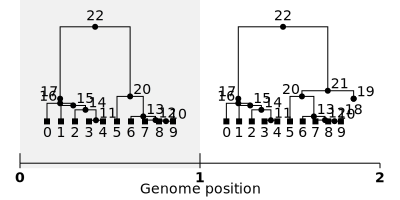

In [2]:
alleles = ["absent", "present"]

# Place one mutation:

num_sites = 2

args = hgt_sim_args.Args(
            sample_size=num_samples,
            num_sites=num_sites,
            gene_conversion_rate=0,
            recombination_rate=0,
            hgt_rate=0.5,
            ce_from_ts=None,
            ce_from_nwk=ce_from_nwk,
            random_seed=randint(1, int(2**32 - 2)),
        )

ts, hgt_edges = hgt_simulation.run_simulate(args)

edges = ts.tables.edges
nodes = ts.tables.nodes
node_times = nodes.time

edge_lengths = np.array([
    node_times[edges.parent[i]] - node_times[edges.child[i]]
    for i in range(len(edges.parent))
])

# Kumulative Wahrscheinlichkeitsverteilung erstellen
cdf = np.cumsum(edge_lengths / np.sum(edge_lengths))

# Zufälligen Ast basierend auf Längen auswählen
random_value = np.random.uniform()
selected_edge_index = np.searchsorted(cdf, random_value)

# Details des ausgewählten Edges
selected_edge = edges[selected_edge_index]
parent_time = node_times[selected_edge.parent]
child_time = node_times[selected_edge.child]

# Zufällige Position innerhalb des Astes
mutation_time = np.random.uniform(child_time, parent_time)

print(f"Mutation platziert auf Edge {selected_edge_index}, Zeit: {mutation_time}")

# Initialize sites:

tables = ts.dump_tables()

position = np.arange(0, num_sites, dtype="uint32")

ancestral_state = [alleles[0]] * num_sites
ancestral_state, ancestral_state_offset = tskit.pack_strings(ancestral_state)

tables.sites.set_columns(
    position=position,
    ancestral_state=ancestral_state,
    ancestral_state_offset=ancestral_state_offset,
)

ts = tables.tree_sequence()

"""
# Mutation hinzufügen: an einer spezifischen Site
mutated_site = 1
tables = ts.dump_tables()
tables.mutations.add_row(site=mutated_site, 
                         node=selected_edge.child, 
                         #time=mutation_time, 
                         derived_state = "present", 
                         metadata=0b00.to_bytes(1),
                        # new = True
                        )

ts = tables.tree_sequence()
"""

ts2 = ts

ts.draw_svg()

In [3]:
ts = ts2

tables = ts.dump_tables()

theta_total_events = theta
rho_total_events = rho * num_sites

root_proba = theta_total_events / (rho_total_events if rho_total_events != 0 else theta)
if not (0 <= root_proba <= 1):
    raise ValueError(f"Invalid theta / rho resulting in a root probability of {root_proba}")

event_rate = rho_total_events + theta_total_events
theta_proba = theta_total_events / event_rate
rho_proba = rho_total_events / event_rate
event_rate /= num_sites

gain_loss_model = msprime.MatrixMutationModel(
    alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [1 - theta_proba, theta_proba],
        [rho_proba, 1 - rho_proba],
    ],
)
#gain_loss_model = PythonMutationMatrixModel(
#        alleles=model.alleles,
#        root_distribution=model.root_distribution,
#        transition_matrix=model.transition_matrix,
#    )

rate_map = msprime.RateMap(position=[0, num_sites], rate=[event_rate])


hgt_generator = hgt_mutations.HGTMutationGenerator(rate_map=rate_map, model=gain_loss_model)


# Fix the hgt_events, such that mutations coming from hgt are counted in correctly.

edges = list(tables.edges)
edges.extend(hgt_edges)

child_ids = {e.child for e in edges}
root_nodes = list({e.parent for e in edges if e.parent not in child_ids})

hgt_generator.apply_mutations(tables, hgt_edges, root_nodes)
hgt_generator.populate_tables(tables)

edges = list(e for e in edges if not e in hgt_edges)
tables.edges.clear()

for e in edges:
    tables.edges.add_row(left=e.left, right=e.right, parent=e.parent, child=e.child)
ts = tables.tree_sequence()


for var in mts.variants():
        gfs_matrix = ts.allele_frequency_spectrum(span_normalise = False, polarised = True)

# print(gfs_matrix)

ts.draw_svg()

NameError: name 'ts2' is not defined

[0. 0. 0. 0. 0. 0.]


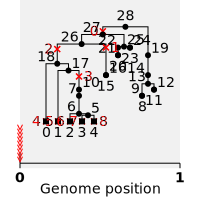

In [40]:
alleles = ["absent", "present"]

num_sites = 1

theta_total_events = 0.5
rho_total_events = 0 * num_sites

root_proba = theta_total_events / (rho_total_events if rho_total_events != 0 else theta)
#if not (0 <= root_proba <= 1):
#    raise ValueError(f"Invalid theta / rho resulting in a root probability of {root_proba}")

event_rate = rho_total_events + theta_total_events
theta_proba = theta_total_events / event_rate
rho_proba = rho_total_events / event_rate
event_rate /= num_sites

gain_loss_model = msprime.MatrixMutationModel(
    alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [1 - theta_proba, theta_proba],
        [rho_proba, 1 - rho_proba],
    ],
)


# Place one mutation:


args = hgt_sim_args.Args(
            sample_size=num_samples,
            num_sites=num_sites,
            gene_conversion_rate=0,
            recombination_rate=0,
            hgt_rate=0.5,
            ce_from_ts=None,
            ce_from_nwk=ce_from_nwk,
            random_seed=randint(1, int(2**32 - 2)),
        )

ts, hgt_edges = hgt_simulation.run_simulate(args)

tables = ts.dump_tables()

position = np.arange(0, num_sites, dtype="uint32")

ancestral_state = [alleles[0]] * num_sites
ancestral_state, ancestral_state_offset = tskit.pack_strings(ancestral_state)

tables.sites.set_columns(
    position=position,
    ancestral_state=ancestral_state,
    ancestral_state_offset=ancestral_state_offset,
)

ts = tables.tree_sequence()


mts = hgt_mutations.sim_mutations(
            ts,
            hgt_edges=hgt_edges,
            event_rate=event_rate,
            model=gain_loss_model,
            one_mutation = False,
        )

for var in mts.variants():
        gfs_matrix = mts.allele_frequency_spectrum(span_normalise = False, polarised = True)

print(gfs_matrix)

mts.draw_svg()

In [41]:
tables = mts.dump_tables()

derived_state, parent_state, metadata_state = _unpack_tables(tables)

derived_state

NameError: name '_unpack_tables' is not defined

In [327]:
alleles = ["absent", "present"]

theta_total_events = theta
rho_total_events = rho * num_sites

root_proba = theta_total_events / (rho_total_events if rho_total_events != 0 else theta)
if not (0 <= root_proba <= 1):
    raise ValueError(f"Invalid theta / rho resulting in a root probability of {root_proba}")

event_rate = rho_total_events + theta_total_events
theta_proba = theta_total_events / event_rate
rho_proba = rho_total_events / event_rate
event_rate /= num_sites

gain_loss_model = msprime.MatrixMutationModel(
    alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [1 - theta_proba, theta_proba],
        [rho_proba, 1 - rho_proba],
    ],
)

tables = ts.dump_tables()

# Set the ancestral state for each site.
# poisson = np.random.poisson(theta / (rho if rho != 0 else 1))
poisson = 0
poisson = min(poisson, num_sites)

position = np.arange(0, num_sites, dtype="uint32")
position = np.random.choice(position, poisson, replace=False)
position.sort()

ancestral_state = [alleles[1]] * poisson
ancestral_state, ancestral_state_offset = tskit.pack_strings(ancestral_state)

tables.sites.set_columns(
    position=position,
    ancestral_state=ancestral_state,
    ancestral_state_offset=ancestral_state_offset,
)
ts = tables.tree_sequence()






# Anfang hgt_mutations.sim_mutations:

tables = ts.dump_tables()

gene_count = tables.sequence_length

gain_loss_model = hgt_mutations.PythonMutationMatrixModel(
    alleles=gain_loss_model.alleles,
    root_distribution=gain_loss_model.root_distribution,
    transition_matrix=gain_loss_model.transition_matrix,
)

rate_map = msprime.RateMap(position=[0, gene_count], rate=[event_rate])

edges = list(tables.edges)
edges.extend(hgt_edges)

child_ids = {e.child for e in edges}
root_nodes = list({e.parent for e in edges if e.parent not in child_ids})

hgt_generator = hgt_mutations.HGTMutationGenerator(rate_map=rate_map, model=gain_loss_model)

ts = hgt_generator.generate(
    tables,
    edges,
    root_nodes,
    randint(0, 4294967295),
    keep=True,
    discrete_genome=True,
)




hgt_generator

In [469]:
# print(mts.tables.edges)
# print(mts.first().draw_text())

# Zugriff auf die Tabellen

0b00.to_bytes(1)

b'\x00'

In [352]:
tables = mts.at(0).dump_tables()


AttributeError: 'Tree' object has no attribute 'dump_tables'

In [316]:
ts_backup = ts

num_sites_test = 10
# Set the ancestral state for each site.
poisson = np.random.poisson(theta / (rho if rho != 0 else 1))
poisson = min(poisson, num_sites_test)

position = np.arange(0, num_sites_test, dtype="uint32")
position = np.random.choice(position, poisson, replace=False)
position.sort()

ancestral_state = [alleles[1]] * poisson
ancestral_state, ancestral_state_offset = tskit.pack_strings(ancestral_state)

print(poisson)
print(position)
print((theta / (rho if rho != 0 else 1)))
print(ancestral_state)
print(ancestral_state_offset)

ts

0
[]
0.625
[]
[0]


In [181]:
# Schritt 1: Sortiere die Ziehungen
selected_trees_sorted = sorted(selected_trees)

# Schritt 2: Zähle Duplikate
from collections import Counter
tree_counts = Counter(selected_trees_sorted)

# Ausgabe der Anzahl der Duplikate
duplicates = {key: count for key, count in tree_counts.items() if count > 1}
print(f"Duplikate und ihre Häufigkeit: {duplicates}")

# Schritt 3: Entferne Duplikate (lasse nur einen Eintrag pro Baum übrig)
unique_trees = list(tree_counts.keys())

len(mts.trees())

Duplikate und ihre Häufigkeit: {}


96

In [121]:
# Hole die Tabellen aus dem TreeSequence-Objekt
tables = mts_list[1].dump_tables()

# 1. Füge eine zufällige Position für die Mutation hinzu
site_position = np.random.uniform(0, mts_list[1].sequence_length)  # Zufällige Position im Bereich [0, sequence_length]
site_id = tables.sites.add_row(position=site_position, ancestral_state="0")

# 2. Wähle einen zufälligen Knoten aus
node_id = np.random.choice(range(mts_list[1].num_nodes))

# 3. Füge die Mutation hinzu
tables.mutations.add_row(site=site_id, node=node_id, derived_state="1")

# 4. Erstelle eine neue TreeSequence mit der Mutation
mutated_tree = tables.tree_sequence()


for var in mutated_tree.variants():
    print(var.genotypes)

with open("mutated_tree.svg", "w") as svg_file:
    svg_file.write(mutated_tree.draw_svg())

<bound method TreeSequence.mutations of <tskit.trees.TreeSequence object at 0x0000019C39A624B0>>
[0 0 0 0 0 0 0 0 0 0]


In [12]:
theta = 2
expected_number_of_mutations = theta * average_tree_length
number_of_gains = np.random.poisson(expected_number_of_mutations)
print(number_of_gains)

21


In [67]:
number_of_mutations = []
for mts in mts_list:
    mutations = sum(tree.num_mutations for tree in mts.trees())
    number_of_mutations.append(mutations)

print(number_of_mutations)
print(expected_number_of_mutations)

print(average_tree_length)
print(theta)

[13, 3, 13, 2, 1, 1, 2, 0, 3, 2, 3, 1, 13, 0, 12, 0, 10, 1, 11]
0.7355953140336466
0.2


In [75]:
print(hgt_rate)
print(sum(tree.total_branch_length for tree in core_tree.trees()))
print(average_tree_length)
print(total_branch_lengths)

tensor(0.6767)
4.338400242348786
7.090114687665711
[5.097504146075549, 6.94044197628146, 8.002941158939326, 6.601718861363333, 9.48883397139835, 6.661285208587734, 9.459366707173045, 7.953704524889576, 4.33840034234883, 6.368376507637036, 7.0150088747674815, 6.642537150789993, 5.517070292067897, 7.811889534543084, 7.046312126774953, 7.648810761033703, 10.495032947571657, 5.3083393713564515, 6.314604602049042]


In [29]:
def simulate_extinction_time(L, rho, hgt_rate, num_samples):
    """
    Simuliert die Zeit bis zur Extinktion eines Zweigungsprozesses.
    
    Parameter:
        L: Die Länge des Core-Baums (nicht direkt verwendet)
        rho: Mutationsrate (nicht direkt verwendet)
        gamma: HGT-Rate (Geburtenrate)
        initial_branches: Anzahl der anfänglichen Zweige (X_0)

    Rückgabewert:
        Zeit bis zur Extinktion
    """
    branches = num_samples
    time = 0.0

    while branches > 0:
        birth_rate = hgt_rate
        if branches > 1:
            death_rate = branches * (branches - 1) / 2
        else:
            death_rate = 0

        total_rate = birth_rate + death_rate
        if total_rate == 0:
            break

        # Wartezeit bis zum nächsten Ereignis
        time_to_next_event = np.random.exponential(1 / total_rate)
        time += time_to_next_event

        # Entscheide ob Geburt oder Tod
        if np.random.rand() < (birth_rate / total_rate):
            branches += 1
        else:
            branches -= 1

    return time

# Beispielhafte Parameter
L = 100  # Beispielkernbaum bei Länge L (nicht direkt verwendet)
rho = 0.01  # Mutationsrate (nicht direkt verwendet)
gamma = 0.1  # HGT-Rate
num_samples = 5  # Anzahl der anfänglichen Zweige

# Berechne die Zeit bis zur Extinktion
extinction_time = simulate_extinction_time(L, rho, gamma, num_samples)
print(f"Zeit bis zur Extinktion: {extinction_time:.2f}")

In [60]:
print(total_branch_lengths)
print(mts_list[1].first().draw_text())
print(core_tree.first().draw_text())

mts

[5.771128597498799, 5.4174097449121525, 6.77904869528533, 6.399279959065085, 8.679570304346026, 8.033348397032984, 9.038932700006043, 5.4174097449121525, 6.78024517220398, 6.613619376945763, 6.298587709217051, 7.107051383156005, 9.306812231266242, 9.747508725826629, 8.028013919945538, 6.422505126013231, 7.621816499411544, 7.5179369690924975, 8.666259532719694]
   18              
 ┏━━┻━━┓           
 ┃    17           
 ┃  ┏━━┻━━┓        
 ┃  ┃    16        
 ┃  ┃  ┏━━┻━━━┓    
 ┃  ┃  ┃     15    
 ┃  ┃  ┃    ┏━┻━━┓ 
 ┃  ┃  ┃    ┃   14 
 ┃  ┃  ┃    ┃   ┏┻┓
 ┃  ┃  ┃   13   ┃ ┃
 ┃  ┃  ┃  ┏━┻┓  ┃ ┃
 ┃  ┃ 12  ┃  ┃  ┃ ┃
 ┃  ┃ ┏┻┓ ┃  ┃  ┃ ┃
 ┃  ┃ ┃ ┃ ┃ 11  ┃ ┃
 ┃  ┃ ┃ ┃ ┃ ┏┻┓ ┃ ┃
10  ┃ ┃ ┃ ┃ ┃ ┃ ┃ ┃
┏┻┓ ┃ ┃ ┃ ┃ ┃ ┃ ┃ ┃
0 1 2 3 4 5 6 7 8 9

             18    
           ┏━━┻━━┓ 
          17     ┃ 
        ┏━━┻━━┓  ┃ 
       16     ┃  ┃ 
    ┏━━━┻━━┓  ┃  ┃ 
   15      ┃  ┃  ┃ 
 ┏━━┻━┓    ┃  ┃  ┃ 
14    ┃    ┃  ┃  ┃ 
┏┻┓   ┃    ┃  ┃  ┃ 
┃ ┃  13    ┃  ┃  ┃ 
┃ ┃  ┏┻━┓  ┃  ┃  ┃ 
┃ ┃  ┃  ┃ 12  ┃ 